# Identify the Sentiments

Final Huanxin Sheng 15220202202189

This is the final project of

Artificial Intelligence and Machine Learning(2023Fall) taught by Prof.Zhonglei Wang at WISE, XMU

In [ ]:
!pip install wordninja
!pip install unidecode
!pip install ktrain
!pip install blurr

In [ ]:
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import wordninja
import unidecode
import ktrain

## 1  Data

Sentiment analysis is contextual mining of text which identifies and extracts subjective information in source material, and helping a business to understand the social sentiment of their brand, product or service while monitoring online conversations. Brands can use this data to measure the success of their products in an objective manner. In this challenge, you are provided with tweet data to predict sentiment on electronic products of netizens.


[Contest/Data Source](https://datahack.analyticsvidhya.com/contest/linguipedia-codefest-natural-language-processing-1/)

### 1.1 Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pathlib import Path
path = Path('/content/drive/MyDrive/人工智能与机器学习/Final-NLP')

### 1.2 Data Preprocessing

In [ ]:
def clean_tweet(text):

    # lower-case all characters
    text=text.lower()

    # remove twitter handles
    text= re.sub(r'@\S+', '',text)

    # remove urls
    text= re.sub(r'http\S+', '',text)
    text= re.sub(r'pic.\S+', '',text)

    # replace unidecode characters
    text=unidecode.unidecode(text)

    # regex only keeps characters
    text= re.sub(r"[^a-zA-Z+']", ' ',text)

    # keep words with length>1 only
    text=re.sub(r'\s+[a-zA-Z]\s+', ' ', text+' ')

    # split words like 'whatisthis' to 'what is this'
    def preprocess_wordninja(sentence):
        def split_words(x):
            x=wordninja.split(x)
            x= [word for word in x if len(word)>1]
            return x
        new_sentence=[ ' '.join(split_words(word)) for word in sentence.split() ]
        return ' '.join(new_sentence)

    text=preprocess_wordninja(text)

    # regex removes repeated spaces, strip removes leading and trailing spaces
    text= re.sub("\s[\s]+", " ",text).strip()

    return text

In [ ]:
train_df = pd.read_csv(path/'train_2kmZucJ.csv')
train_df = train_df.rename(columns={'tweet':'text'})
train_df['text']=train_df['text'].apply(lambda x: clean_tweet(x))
train_df.head()

id  label                                               text
0   1      0  fingerprint pregnancy test android apps beauti...
1   2      0  finally trans paran silicon case thanks to my ...
2   3      0  we love this would you go talk make memories u...
3   4      0  i'm wired know i'm george was made that way ip...
4   5      1  what amazing service apple won't even talk to ...

In [ ]:
# Count number of Positive->0 and Negative->1 in training data
train_df['label'].value_counts()

0    5894
1    2026
Name: label, dtype: int64

In [ ]:
test_df = pd.read_csv(path/'test_oJQbWVk.csv')
test_df = test_df.rename(columns={'tweet':'text'})
test_df['text']=test_df['text'].apply(lambda x: clean_tweet(x))
test_df.head()

id                                               text
0  7921  hate the new iphone upgrade won't let me downl...
1  7922  currently shitting my fucking pants apple imac...
2  7923  i'd like to puts some cd roms on my ipad is th...
3  7924  my ipod is officially dead lost all my and vid...
4  7925  been fighting itunes all night only want the m...

### 1.3 Word Cloud Depiction

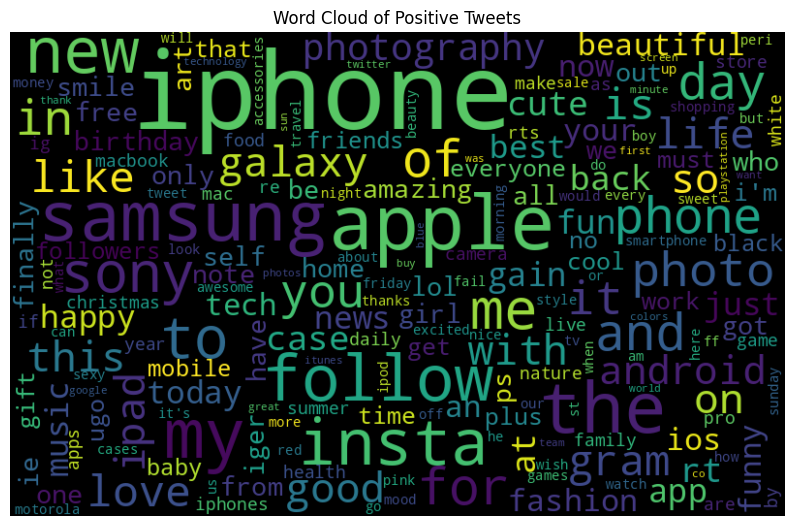

In [ ]:
positive= train_df[train_df['label']==0]
all_words = ' '.join([text for text in positive['text']])

#Counting Frequency
from collections import Counter
word_counts = Counter(all_words.split())
sorted_word_counts = dict(sorted(word_counts.items(), key=lambda x: x[1], reverse=True))

#Word Cloud Depiction
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=110, colormap='viridis', collocations=False).generate_from_frequencies(sorted_word_counts)

plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Word Cloud of Positive Tweets')
plt.axis('off')
plt.show()

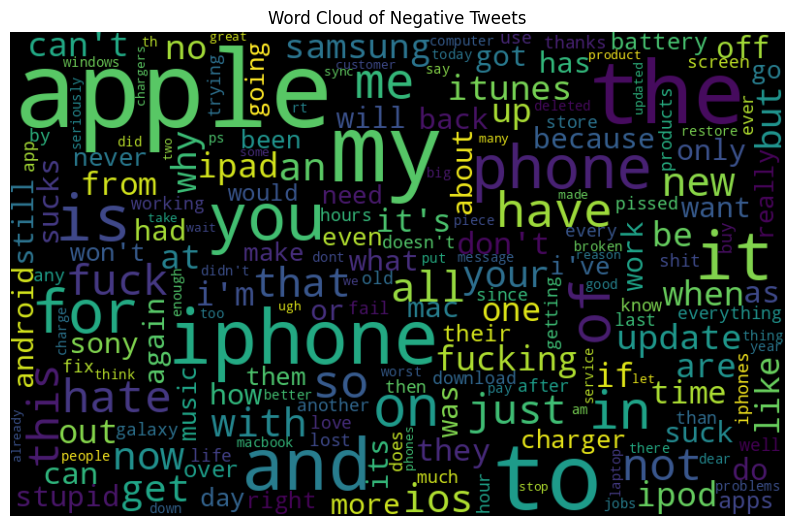

In [ ]:
negative= train_df[train_df['label']==1]
all_words = ' '.join([text for text in negative['text']])

#Counting Frequency
from collections import Counter
word_counts = Counter(all_words.split())
sorted_word_counts = dict(sorted(word_counts.items(), key=lambda x: x[1], reverse=True))

#Word Cloud Depiction
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=110, colormap='viridis', collocations=False).generate_from_frequencies(sorted_word_counts)

plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Word Cloud of Negative Tweets')
plt.axis('off')
plt.show()

## 2 Model

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_df.drop(['label'], axis=1), train_df['label'], test_size=0.2, random_state=42)

In [ ]:
X_train

id                                               text
4252  4253  cool car wash idea the island bank holiday mon...
4428  4429  photo th birthday to the sony walkman at nobod...
7374  7375  ipad are the biggest pile of fucking on the pl...
1410  1411  yearbook hmmm mm insta gram insta good togethe...
7896  7897  so pissed macbook crashes apple company does n...
...    ...                                                ...
5226  5227  shana to va jewish new year everyone may your ...
5390  5391  i'm so sick of buying new cell phone chargers ...
860    861  it want it have it download the free iphone ap...
7603  7604  photo nikos iphone beach holiday iphone black ...
7270  7271  just got an iphone he he iphone apple new fina...

[6336 rows x 2 columns]

In [ ]:
y_train

4252    0
4428    0
7374    1
1410    0
7896    1
       ..
5226    0
5390    1
860     0
7603    0
7270    1
Name: label, Length: 6336, dtype: int64

In [ ]:
text_column = 'text'
if text_column in X_train.columns:
    train_list = X_train[text_column].astype(str).tolist()
else:
    print(f"Error: '{text_column}' column not found in the DataFrame.")

if text_column in X_val.columns:
    val_list = X_val[text_column].astype(str).tolist()
else:
    print(f"Error: '{text_column}' column not found in the DataFrame.")

### 2.1 Model 1: AWD-LSTM

Stephen Merity, Nitish Shirish Keskar, Richard Socher:
Regularizing and Optimizing LSTM Language Models. ICLR (Poster) 2018

In [ ]:
from fastai.text.all import *

In [ ]:
## Creating a Text Data loader for language model
df_all = pd.concat([train_df.drop(['label'], axis=1),test_df])
TDL_Train = TextDataLoaders.from_df(df_all, text_col=1, is_lm=True)
TDL_Train.show_batch(max_n=5)

In [ ]:
## Initiating the language model
AWD_LSTM_learn = language_model_learner(
    TDL_Train,
    AWD_LSTM,
    metrics=[accuracy, Perplexity()],
    path=path,
    wd=0.1).to_fp16()

In [ ]:
## Training last layer
AWD_LSTM_learn.fit_one_cycle(5, 1e-2)

In [ ]:
## Training all layers
AWD_LSTM_learn.unfreeze()
AWD_LSTM_learn.fit_one_cycle(10, 1e-3)

In [ ]:
## Saving encoder
AWD_LSTM_learn.save_encoder('AWD_LSTM_learn')

In [ ]:
## Creating a dataloader
TDL_Classify = TextDataLoaders.from_df(
    pd.concat([X_train, y_train], axis=1),
    valid_pct=0.2,
    seed=42,
    text_col=1,
    label_col=2,
    text_vocab=TDL_Train.vocab)

In [ ]:
## Checking if everything is working fine
TDL_Classify.show_batch(max_n=5)

In [ ]:
## Defining our text classifier
AWD_LSTM_Classifier = text_classifier_learner(TDL_Classify , AWD_LSTM, drop_mult=1, metrics=accuracy)
AWD_LSTM_Classifier.path = path

In [ ]:
## Loading Language model encoder weights trained in previous section
AWD_LSTM_Classifier = AWD_LSTM_Classifier.load_encoder(file='AWD_LSTM_learn')

In [ ]:
## Finetuning last layer
AWD_LSTM_Classifier.fit_one_cycle(5, slice(1e-4, 1e-2))

In [ ]:
## Finetuning last 2 layers and progressive learning rate
AWD_LSTM_Classifier.freeze_to(-2)
AWD_LSTM_Classifier.fit_one_cycle(5, slice(1e-4,1e-2))

In [ ]:
## Finetuning last 3 layers and progressive learning rate
AWD_LSTM_Classifier.freeze_to(-3)
AWD_LSTM_Classifier.fit_one_cycle(5, slice(1e-4,1e-2))

In [ ]:
## Training entire model
AWD_LSTM_Classifier.unfreeze()
AWD_LSTM_Classifier.fit_one_cycle(10, slice(1e-5,1e-3))

In [ ]:
## Save model weights
AWD_LSTM_Classifier.save('AWD_LSTM_Classifier')

Path('/content/drive/MyDrive/人工智能与机器学习/Final-NLP/models/AWD_LSTM_Classifier.pth')

In [ ]:
## Getting testing data and doing predictions
test_dl = AWD_LSTM_Classifier.dls.test_dl(X_val)
preds, _ = AWD_LSTM_Classifier.get_preds(dl=test_dl)
ppp1 = preds[:, 1].numpy()#predicted_positive_probabilities
y_val = np.array(y_val)

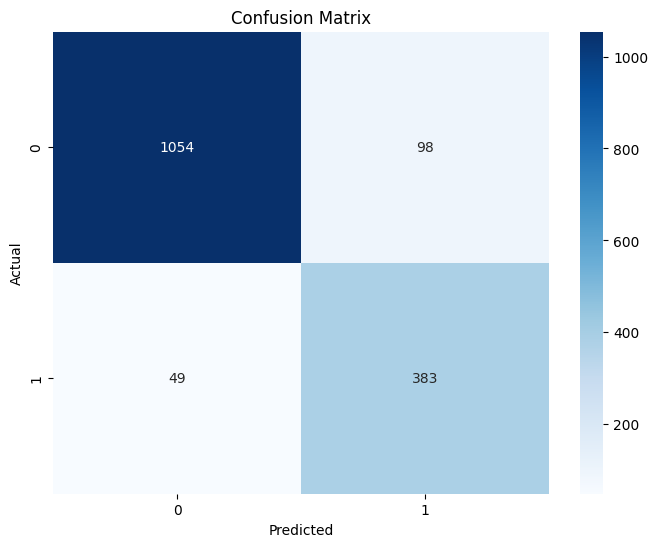

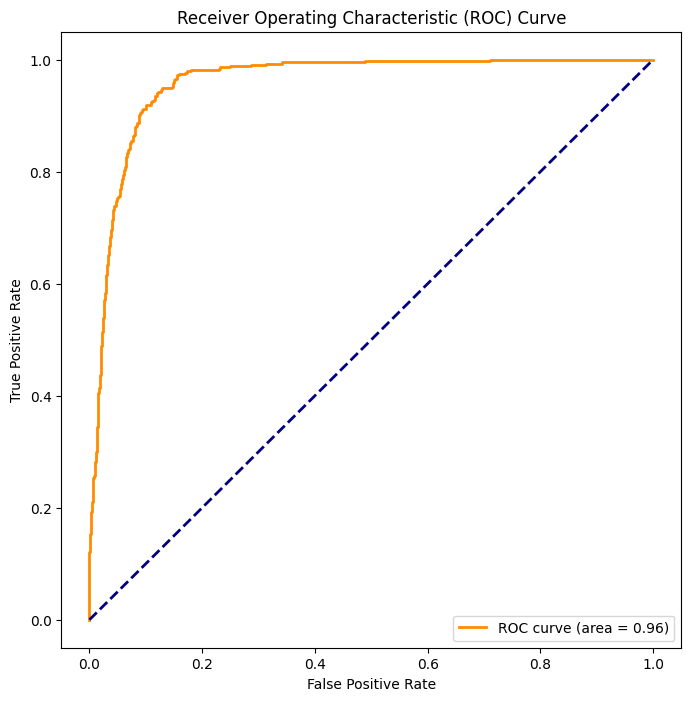

In [ ]:
from sklearn.metrics import roc_curve, auc

from sklearn.metrics import confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt


# 计算并绘制混淆矩阵
conf_matrix = confusion_matrix(y_val, (ppp1 > 0.5).astype(int))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, thresholds = roc_curve(y_val,ppp1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### 2.2 Model 2: Bert

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
Bert_Based = BertForSequenceClassification.from_pretrained('bert-base-uncased')


In [ ]:
inputs = tokenizer(train_list, return_tensors="pt", truncation=True, padding=True)
labels = torch.tensor(y_train.tolist(), dtype=torch.float32)

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# 将模型和数据移到GPU上
Bert_Based.to('cuda')
inputs_cuda = {key: value.to('cuda') for key, value in inputs.items()}
labels_tensor_cuda = labels.to('cuda')

dataset = TensorDataset(inputs_cuda['input_ids'], inputs_cuda['attention_mask'], labels_tensor_cuda)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

optimizer = torch.optim.AdamW(Bert_Based.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()

# 记录训练过程中的损失和准确率
train_loss_history = []
train_accuracy_history = []

In [ ]:
for epoch in range(5):
    total_loss = 0.0
    total_correct_predictions = 0
    total_samples = 0

    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f'Epoch {epoch + 1}/{5}')

    for batch_idx, batch in progress_bar:
        optimizer.zero_grad()
        outputs = Bert_Based(input_ids=batch[0], attention_mask=batch[1])
        logits = outputs.logits
        loss = criterion(logits, batch[2].long())

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted_labels = torch.max(logits, 1)
        total_correct_predictions += (predicted_labels == batch[2]).sum().item()
        total_samples += batch[2].size(0)

        progress_bar.set_postfix({'Loss': loss.item(), 'Accuracy': total_correct_predictions / total_samples})

    epoch_loss = total_loss / len(dataloader)
    epoch_accuracy = total_correct_predictions / total_samples

    train_loss_history.append(epoch_loss)
    train_accuracy_history.append(epoch_accuracy)

    print(f'Epoch {epoch + 1}/{3}, Average Loss: {epoch_loss:.4f}, Average Accuracy: {epoch_accuracy:.4f}')

Epoch 1/5: 100%|██████████| 50/50 [00:18<00:00,  2.68it/s, Loss=0.245, Accuracy=0.798]


Epoch 1/3, Average Loss: 0.4215, Average Accuracy: 0.7981


Epoch 2/5: 100%|██████████| 50/50 [00:18<00:00,  2.67it/s, Loss=0.22, Accuracy=0.919]


Epoch 2/3, Average Loss: 0.2122, Average Accuracy: 0.9192


Epoch 3/5: 100%|██████████| 50/50 [00:19<00:00,  2.61it/s, Loss=0.0807, Accuracy=0.942]


Epoch 3/3, Average Loss: 0.1584, Average Accuracy: 0.9421


Epoch 4/5: 100%|██████████| 50/50 [00:18<00:00,  2.67it/s, Loss=0.109, Accuracy=0.96]


Epoch 4/3, Average Loss: 0.1215, Average Accuracy: 0.9601


Epoch 5/5: 100%|██████████| 50/50 [00:18<00:00,  2.67it/s, Loss=0.0686, Accuracy=0.974]

Epoch 5/3, Average Loss: 0.0889, Average Accuracy: 0.9740


In [ ]:
# 预测验证集
# 数据准备
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
val_tokenized = tokenizer(val_list, padding=True, truncation=True, return_tensors='pt')
val_list_cuda = {key: value.to('cuda') for key, value in val_tokenized.items()}
labels_val_tensor_cuda = torch.tensor(y_val, dtype=torch.long).to('cuda')

# 开始验证
Bert_Based.eval()
with torch.no_grad():
    outputs_val = Bert_Based(input_ids=val_list_cuda['input_ids'], attention_mask=val_list_cuda['attention_mask'])
    logits_val = outputs_val.logits
ppp2 = torch.softmax(logits_val, dim=1)[:, 1].cpu().numpy()

In [ ]:
# 保存模型的状态字典
model_state_dict = Bert_Based.state_dict()

# 保存模型参数
torch.save(model_state_dict, 'bert_based_model.pth')

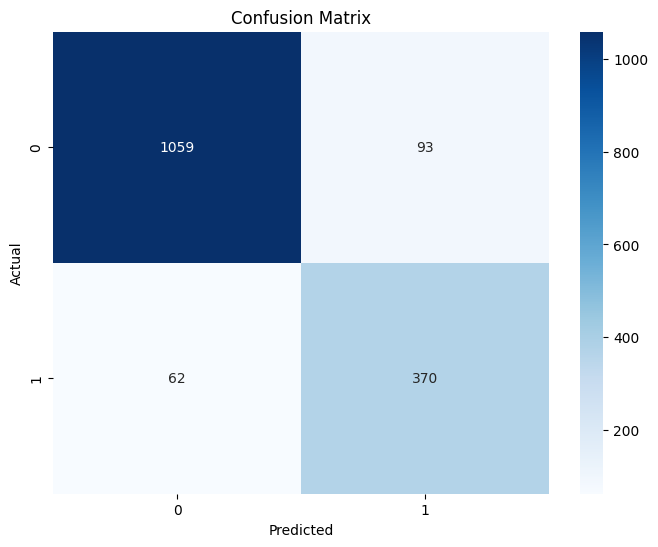

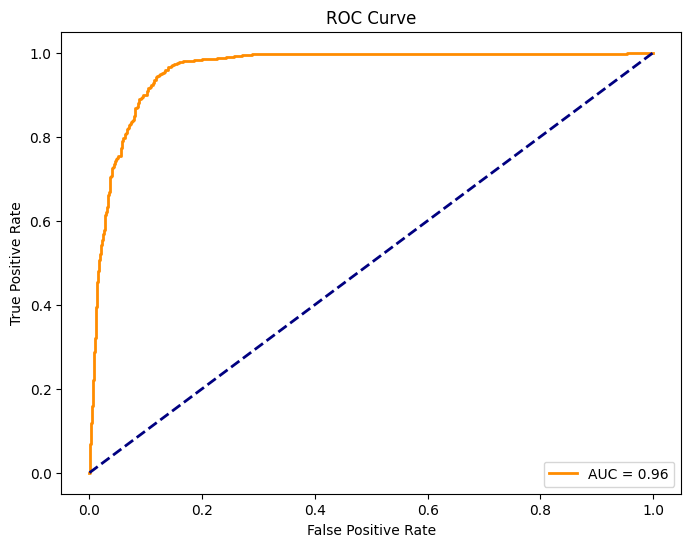

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt


# 计算并绘制混淆矩阵
conf_matrix = confusion_matrix(y_val, (ppp2 > 0.5).astype(int))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 计算并绘制ROC曲线
fpr, tpr, thresholds = roc_curve(y_val, ppp2)
roc_auc = roc_auc_score(y_val, ppp2)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


### 2.3 Model 3: Roberta

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch

In [ ]:
# 加载 Roberta tokenizer 和模型
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
Roberta_Based = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

In [ ]:
inputs = tokenizer(train_list, return_tensors="pt", truncation=True, padding=True)
labels = torch.tensor(y_train.tolist(), dtype=torch.float32)

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# 将模型和数据移到GPU上
Roberta_Based.to('cuda')
inputs_cuda = {key: value.to('cuda') for key, value in inputs.items()}
labels_tensor_cuda = labels.to('cuda')

dataset = TensorDataset(inputs_cuda['input_ids'], inputs_cuda['attention_mask'], labels_tensor_cuda)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

optimizer = torch.optim.AdamW(Roberta_Based.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()

# 记录训练过程中的损失和准确率
train_loss_history = []
train_accuracy_history = []

In [ ]:
for epoch in range(5):
    total_loss = 0.0
    total_correct_predictions = 0
    total_samples = 0

    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f'Epoch {epoch + 1}/5')

    for batch_idx, batch in progress_bar:
        optimizer.zero_grad()
        outputs = Roberta_Based(input_ids=batch[0], attention_mask=batch[1])
        logits = outputs.logits
        loss = criterion(logits, batch[2].long())

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted_labels = torch.max(logits, 1)
        total_correct_predictions += (predicted_labels == batch[2]).sum().item()
        total_samples += batch[2].size(0)

        progress_bar.set_postfix({'Loss': loss.item(), 'Accuracy': total_correct_predictions / total_samples})

    epoch_loss = total_loss / len(dataloader)
    epoch_accuracy = total_correct_predictions / total_samples

    train_loss_history.append(epoch_loss)
    train_accuracy_history.append(epoch_accuracy)

    print(f'Epoch {epoch + 1}/5, Average Loss: {epoch_loss:.4f}, Average Accuracy: {epoch_accuracy:.4f}')


Epoch 1/5: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s, Loss=0.401, Accuracy=0.726]


Epoch 1/5, Average Loss: 0.5107, Average Accuracy: 0.7259


Epoch 2/5: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s, Loss=0.24, Accuracy=0.823]


Epoch 2/5, Average Loss: 0.2927, Average Accuracy: 0.8232


Epoch 3/5: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s, Loss=0.18, Accuracy=0.917]


Epoch 3/5, Average Loss: 0.2010, Average Accuracy: 0.9170


Epoch 4/5: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s, Loss=0.12, Accuracy=0.935]


Epoch 4/5, Average Loss: 0.1616, Average Accuracy: 0.9350


Epoch 5/5: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s, Loss=0.137, Accuracy=0.948]

Epoch 5/5, Average Loss: 0.1381, Average Accuracy: 0.9481


In [ ]:
# 预测验证集
# 数据准备
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')  # 使用Roberta的tokenizer
val_tokenized = tokenizer(val_list, padding=True, truncation=True, return_tensors='pt')
val_list_cuda = {key: value.to('cuda') for key, value in val_tokenized.items()}
labels_val_tensor_cuda = torch.tensor(y_val, dtype=torch.long).to('cuda')

# 开始验证
Roberta_Based.eval()
with torch.no_grad():
    outputs_val = Roberta_Based(input_ids=val_list_cuda['input_ids'], attention_mask=val_list_cuda['attention_mask'])
    logits_val = outputs_val.logits
ppp3 = torch.softmax(logits_val, dim=1)[:, 1].cpu().numpy()


In [ ]:
# 保存模型的状态字典
model_state_dict = Roberta_Based.state_dict()

# 保存模型参数
torch.save(model_state_dict, 'roberta_based_model.pth')

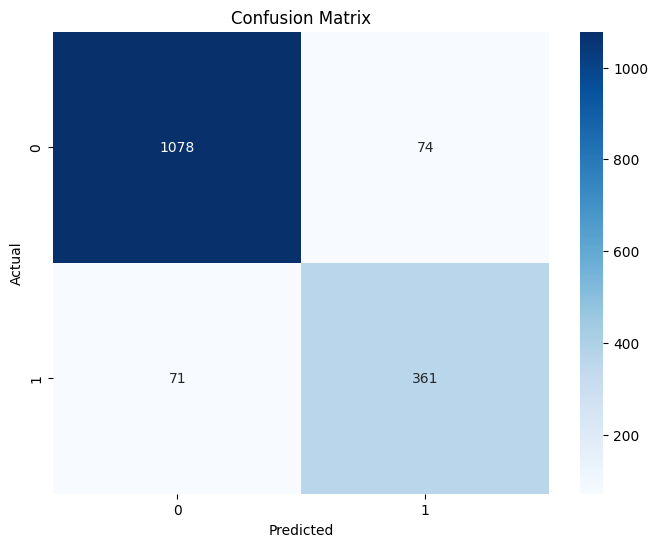

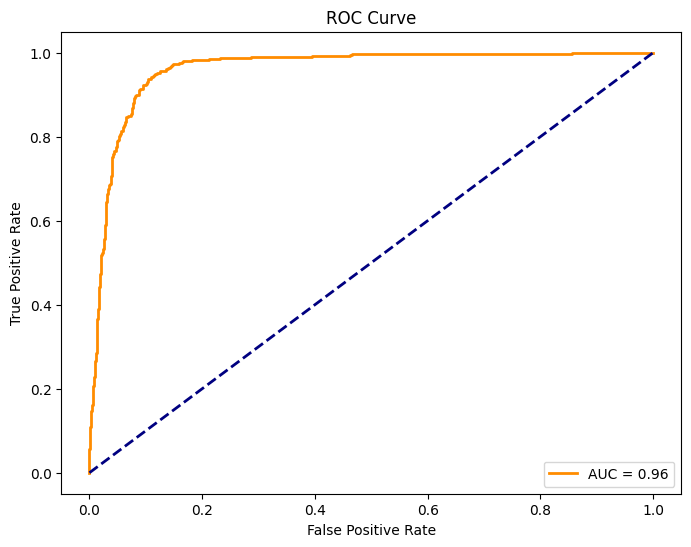

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# 计算并绘制混淆矩阵
conf_matrix = confusion_matrix(y_val, (ppp3 > 0.5).astype(int))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 计算并绘制ROC曲线
fpr, tpr, thresholds = roc_curve(y_val, ppp3)
roc_auc = roc_auc_score(y_val, ppp3)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


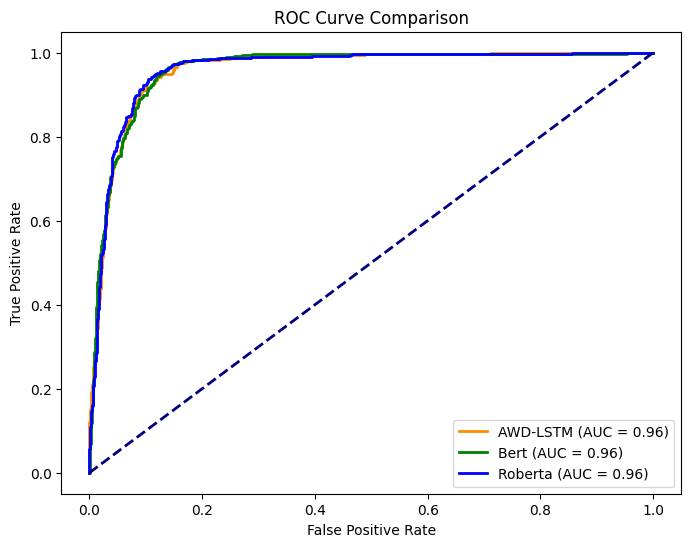

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr1, tpr1, _ = roc_curve(y_val, ppp1)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(y_val, ppp2)
roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, thresholds = roc_curve(y_val, ppp3)
roc_auc3 = auc(fpr3, tpr3)

plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label=f'AWD-LSTM (AUC = {roc_auc1:.2f})')
plt.plot(fpr2, tpr2, color='green', lw=2, label=f'Bert (AUC = {roc_auc2:.2f})')
plt.plot(fpr3, tpr3, color='blue', lw=2, label=f'Roberta (AUC = {roc_auc3:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


## 3  Test

### 3.1 Data Preparation

In [ ]:
X_train = train_df.drop(['label'], axis=1)
y_train = train_df['label']
X_test = test_df

In [ ]:
text_column = 'text'
if text_column in X_train.columns:
    train_list = X_train[text_column].astype(str).tolist()
else:
    print(f"Error: '{text_column}' column not found in the DataFrame.")

if text_column in X_test.columns:
    test_list = X_test[text_column].astype(str).tolist()
else:
    print(f"Error: '{text_column}' column not found in the DataFrame.")

### 3.2 Model Prediction

In [ ]:
# Model 1: AWD-LSTM
from fastai.text.all import *
df_all = pd.concat([train_df.drop(['label'], axis=1),test_df])
TDL_Train = TextDataLoaders.from_df(df_all, text_col=1, is_lm=True)
TDL_Classify = TextDataLoaders.from_df(
    pd.concat([X_train, y_train], axis=1),
    valid_pct=0.2,
    seed=42,
    text_col=1,
    label_col=2,
    text_vocab=TDL_Train.vocab)

AWD_LSTM_Classifier = text_classifier_learner(TDL_Classify , AWD_LSTM, drop_mult=1, metrics=accuracy)
AWD_LSTM_Classifier.path = path
AWD_LSTM_Classifier = AWD_LSTM_Classifier.load_encoder(file='AWD_LSTM_learn')

AWD_LSTM_Classifier.fit_one_cycle(5, slice(1e-4, 1e-2))

AWD_LSTM_Classifier.freeze_to(-2)
AWD_LSTM_Classifier.fit_one_cycle(5, slice(1e-4,1e-2))

AWD_LSTM_Classifier.freeze_to(-3)
AWD_LSTM_Classifier.fit_one_cycle(5, slice(1e-4,1e-2))

AWD_LSTM_Classifier.unfreeze()
AWD_LSTM_Classifier.fit_one_cycle(10, slice(1e-5,1e-3))

## Getting testing data and doing predictions
test_dl = AWD_LSTM_Classifier.dls.test_dl(X_test)
preds, _ = AWD_LSTM_Classifier.get_preds(dl=test_dl)
ppp1 = preds[:, 1]#predicted_positive_probabilities

del TDL_Classify, AWD_LSTM_Classifier, test_dl, preds

In [ ]:
df = pd.DataFrame(ppp1, columns=['ppp1'])
df.to_csv('ppp1.csv', index=False)

In [ ]:
# Model 2: Bert
from transformers import BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
Bert_Based = BertForSequenceClassification.from_pretrained('bert-base-uncased')

inputs = tokenizer(train_list, return_tensors="pt", truncation=True, padding=True)
labels = torch.tensor(y_train.tolist(), dtype=torch.float32)

import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
Bert_Based.to('cuda')
inputs_cuda = {key: value.to('cuda') for key, value in inputs.items()}
labels_tensor_cuda = labels.to('cuda')
dataset = TensorDataset(inputs_cuda['input_ids'], inputs_cuda['attention_mask'], labels_tensor_cuda)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
optimizer = torch.optim.AdamW(Bert_Based.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()
train_loss_history = []
train_accuracy_history = []

for epoch in range(5):
    total_loss = 0.0
    total_correct_predictions = 0
    total_samples = 0

    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f'Epoch {epoch + 1}/{5}')

    for batch_idx, batch in progress_bar:
        optimizer.zero_grad()
        outputs = Bert_Based(input_ids=batch[0], attention_mask=batch[1])
        logits = outputs.logits
        loss = criterion(logits, batch[2].long())

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted_labels = torch.max(logits, 1)
        total_correct_predictions += (predicted_labels == batch[2]).sum().item()
        total_samples += batch[2].size(0)

        progress_bar.set_postfix({'Loss': loss.item(), 'Accuracy': total_correct_predictions / total_samples})

    epoch_loss = total_loss / len(dataloader)
    epoch_accuracy = total_correct_predictions / total_samples

    train_loss_history.append(epoch_loss)
    train_accuracy_history.append(epoch_accuracy)

    print(f'Epoch {epoch + 1}/{3}, Average Loss: {epoch_loss:.4f}, Average Accuracy: {epoch_accuracy:.4f}')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
test_tokenized = tokenizer(test_list, padding=True, truncation=True, return_tensors='pt')
test_list_cuda = {key: value.to('cuda') for key, value in test_tokenized.items()}

Bert_Based.eval()
with torch.no_grad():
    outputs_test = Bert_Based(input_ids=test_list_cuda['input_ids'], attention_mask=test_list_cuda['attention_mask'])
    logits_test = outputs_test.logits
ppp2 = torch.softmax(logits_test, dim=1)[:, 1].cpu().numpy()

del tokenizer, Bert_Based, inputs, labels

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Epoch 1/5: 100%|██████████| 62/62 [00:23<00:00,  2.60it/s, Loss=0.251, Accuracy=0.865]


Epoch 1/3, Average Loss: 0.3154, Average Accuracy: 0.8654


Epoch 2/5: 100%|██████████| 62/62 [00:23<00:00,  2.60it/s, Loss=0.247, Accuracy=0.927]


Epoch 2/3, Average Loss: 0.1903, Average Accuracy: 0.9274


Epoch 3/5: 100%|██████████| 62/62 [00:23<00:00,  2.60it/s, Loss=0.173, Accuracy=0.958]


Epoch 3/3, Average Loss: 0.1324, Average Accuracy: 0.9576


Epoch 4/5: 100%|██████████| 62/62 [00:23<00:00,  2.60it/s, Loss=0.0362, Accuracy=0.977]


Epoch 4/3, Average Loss: 0.0858, Average Accuracy: 0.9765


Epoch 5/5: 100%|██████████| 62/62 [00:23<00:00,  2.60it/s, Loss=0.0627, Accuracy=0.987]


Epoch 5/3, Average Loss: 0.0548, Average Accuracy: 0.9866


In [ ]:
df = pd.DataFrame(ppp2, columns=['ppp2'])
df.to_csv('ppp2.csv', index=False)

In [ ]:
# Model 3: Roberta
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
Roberta_Based = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

inputs = tokenizer(train_list, return_tensors="pt", truncation=True, padding=True)
labels = torch.tensor(y_train.tolist(), dtype=torch.float32)

from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

Roberta_Based.to('cuda')
inputs_cuda = {key: value.to('cuda') for key, value in inputs.items()}
labels_tensor_cuda = labels.to('cuda')

dataset = TensorDataset(inputs_cuda['input_ids'], inputs_cuda['attention_mask'], labels_tensor_cuda)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

optimizer = torch.optim.AdamW(Roberta_Based.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()

train_loss_history = []
train_accuracy_history = []

for epoch in range(5):
    total_loss = 0.0
    total_correct_predictions = 0
    total_samples = 0

    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f'Epoch {epoch + 1}/5')

    for batch_idx, batch in progress_bar:
        optimizer.zero_grad()
        outputs = Roberta_Based(input_ids=batch[0], attention_mask=batch[1])
        logits = outputs.logits
        loss = criterion(logits, batch[2].long())

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted_labels = torch.max(logits, 1)
        total_correct_predictions += (predicted_labels == batch[2]).sum().item()
        total_samples += batch[2].size(0)

        progress_bar.set_postfix({'Loss': loss.item(), 'Accuracy': total_correct_predictions / total_samples})

    epoch_loss = total_loss / len(dataloader)
    epoch_accuracy = total_correct_predictions / total_samples

    train_loss_history.append(epoch_loss)
    train_accuracy_history.append(epoch_accuracy)

    print(f'Epoch {epoch + 1}/5, Average Loss: {epoch_loss:.4f}, Average Accuracy: {epoch_accuracy:.4f}')

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
test_tokenized = tokenizer(test_list, padding=True, truncation=True, return_tensors='pt')
test_list_cuda = {key: value.to('cuda') for key, value in test_tokenized.items()}

# 开始验证
Roberta_Based.eval()
with torch.no_grad():
    outputs_test = Roberta_Based(input_ids=test_list_cuda['input_ids'], attention_mask=test_list_cuda['attention_mask'])
    logits_test = outputs_test.logits
ppp3 = torch.softmax(logits_test, dim=1)[:, 1].cpu().numpy()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Epoch 1/5: 100%|██████████| 31/31 [00:29<00:00,  1.04it/s, Loss=0.319, Accuracy=0.728]


Epoch 1/5, Average Loss: 0.4659, Average Accuracy: 0.7277


Epoch 2/5: 100%|██████████| 31/31 [00:26<00:00,  1.19it/s, Loss=0.243, Accuracy=0.877]


Epoch 2/5, Average Loss: 0.2550, Average Accuracy: 0.8774


Epoch 3/5: 100%|██████████| 31/31 [00:25<00:00,  1.20it/s, Loss=0.164, Accuracy=0.923]


Epoch 3/5, Average Loss: 0.1887, Average Accuracy: 0.9235


Epoch 4/5: 100%|██████████| 31/31 [00:25<00:00,  1.20it/s, Loss=0.162, Accuracy=0.94]


Epoch 4/5, Average Loss: 0.1548, Average Accuracy: 0.9402


Epoch 5/5: 100%|██████████| 31/31 [00:25<00:00,  1.20it/s, Loss=0.069, Accuracy=0.954]


Epoch 5/5, Average Loss: 0.1251, Average Accuracy: 0.9535


In [ ]:
df = pd.DataFrame(ppp3, columns=['ppp3'])
df.to_csv('ppp3.csv', index=False)

### 3.3 Ensemble Results

In [ ]:
ppp1 = pd.read_csv(path/'ppp1.csv')
ppp2 = pd.read_csv(path/'ppp2.csv')
ppp3 = pd.read_csv(path/'ppp3.csv')

result1 = (ppp1 > 0.5).astype(int)
result2 = (ppp2 > 0.5).astype(int)
result3 = (ppp3 > 0.5).astype(int)

In [ ]:
#Ordinary Averaging
average_array = (ppp1 + ppp2 + ppp3) / 3
Average_result = (average_array > 0.5).astype(int)
Average_result

ppp1
0        1
1        1
2        1
3        1
4        1
...    ...
1948     0
1949     0
1950     1
1951     0
1952     0

[1953 rows x 1 columns]

In [ ]:
#Hard Voting
vote_result = np.sum([result1, result2, result3], axis=0) > 1
vote_result = vote_result.astype(int)
vote_result

array([[1],
       [1],
       [1],
       ...,
       [1],
       [0],
       [0]])

## 4 Results

In [ ]:
submission_df = pd.read_csv(path/'sample_submission_LnhVWA4.csv')
submission_df

id  label
0     7921      0
1     7922      0
2     7923      0
3     7924      0
4     7925      0
...    ...    ...
1948  9869      0
1949  9870      0
1950  9871      0
1951  9872      0
1952  9873      0

[1953 rows x 2 columns]

### 4.1 Individual Model

In [ ]:
AWD_LSTM_Result = submission_df
AWD_LSTM_Result['label'] = result1
AWD_LSTM_Result.to_csv('AWD_LSTM_Result.csv', index=False)

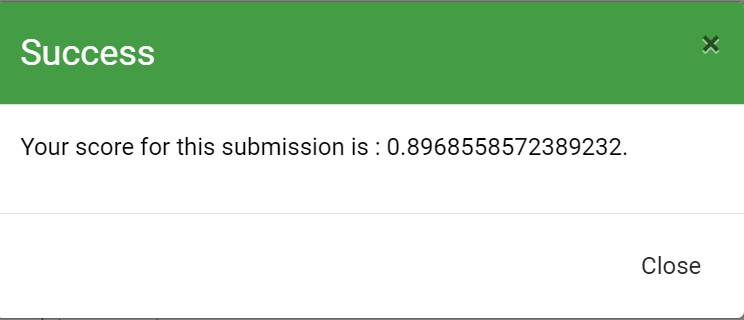

In [ ]:
Bert_Result = submission_df
Bert_Result['label'] = result2
Bert_Result.to_csv('Bert_Result.csv', index=False)

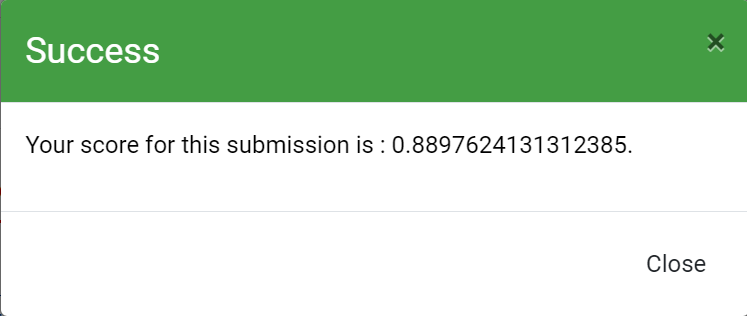

In [ ]:
Roberta_Result = submission_df
Roberta_Result['label'] = result3
Roberta_Result.to_csv('Roberta_Result.csv', index=False)

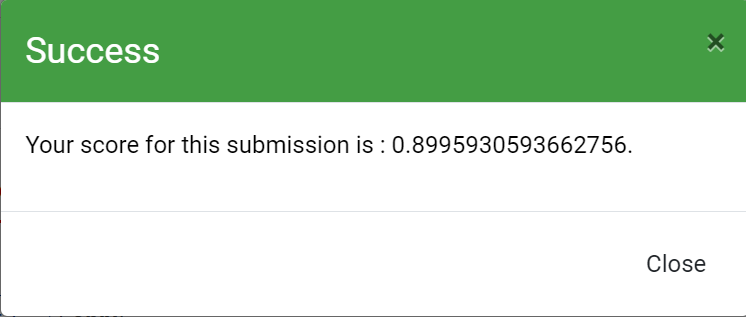

### 4.2 Ensemble Results:

In [ ]:
#Ordinary Averaging
Average_Result = submission_df
Average_Result['label'] = Average_result['ppp1']
Average_Result.to_csv('Average_result.csv', index=False)
Average_Result

id  label
0     7921      1
1     7922      1
2     7923      1
3     7924      1
4     7925      1
...    ...    ...
1948  9869      0
1949  9870      0
1950  9871      1
1951  9872      0
1952  9873      0

[1953 rows x 2 columns]

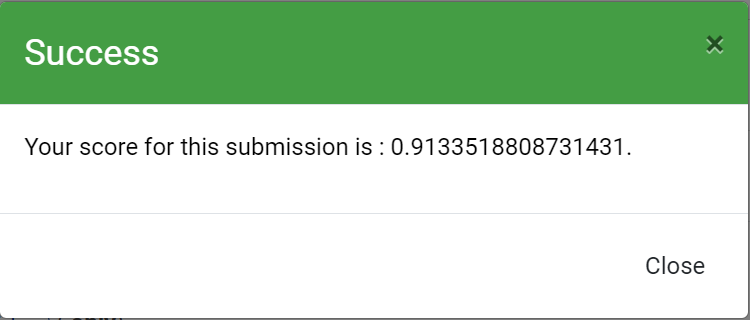

In [ ]:
#Hard Voting
Vote_Result = submission_df
Vote_Result['label'] = vote_result
Vote_Result.to_csv('Vote_result.csv', index=False)
Vote_Result

id  label
0     7921      1
1     7922      1
2     7923      1
3     7924      1
4     7925      1
...    ...    ...
1948  9869      0
1949  9870      0
1950  9871      1
1951  9872      0
1952  9873      0

[1953 rows x 2 columns]

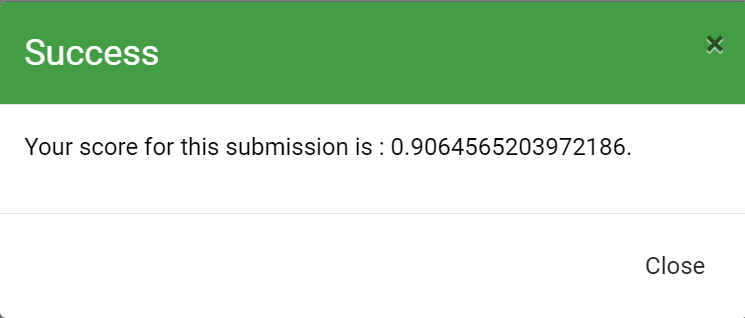

### 4.3 Final Rank

https://datahack.analyticsvidhya.com/contest/linguipedia-codefest-natural-language-processing-1/#LeaderBoard

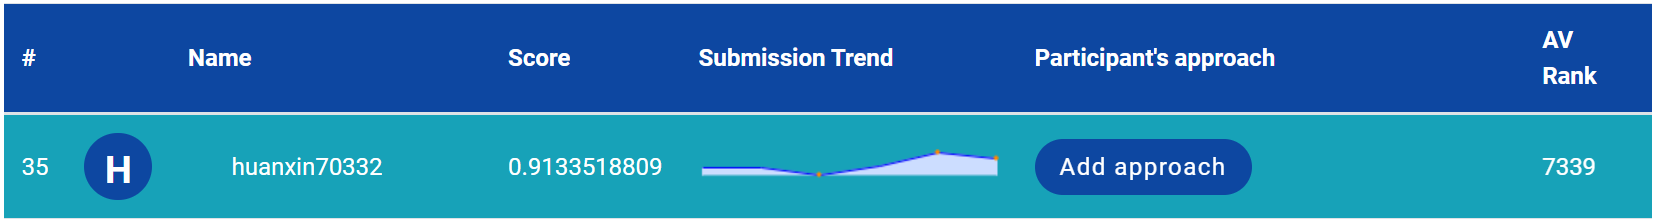